# 깊이 추정 결과 분석

## 0. Setting

In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

gt_path = '/home/work/main/jpark/Event_camera/RAM_Net/checkpoint/pretrained/output/video/gt/'
input_path = '/home/work/main/jpark/Event_camera/RAM_Net/checkpoint/pretrained/output/video/inputs/'
pred_path = '/home/work/main/jpark/Event_camera/RAM_Net/checkpoint/pretrained/output/video/predictions/'
error_path = '/home/work/main/jpark/Event_camera/RAM_Net/checkpoint/pretrained/output/video/errors/'
output_path = '/home/work/main/jpark/Event_camera/RAM_Net/output/'

gt_list = sorted([os.path.join(gt_path, ele_path) for ele_path in (os.listdir(gt_path))])
input_list = sorted([os.path.join(input_path, ele_path) for ele_path in (os.listdir(input_path))])
pred_list = sorted([os.path.join(pred_path, ele_path) for ele_path in (os.listdir(pred_path))])
print("Num of Path:",len(gt_list), len(input_list), len(pred_list))

Num of Path: 2304 2304 2304


## 1. Depth Error Map

In [35]:
thr = 1905
for i, (gt, input, pred) in enumerate(zip(gt_list[thr-5:thr], input_list[thr-5:thr], pred_list[thr-5:thr])):
    save_path = [gt, input, pred]
    gt = cv2.cvtColor(cv2.imread(gt), cv2.COLOR_BGR2GRAY).astype('float32')
    input = cv2.cvtColor(cv2.imread(input), cv2.COLOR_BGR2GRAY).astype('float32')
    pred = cv2.cvtColor(cv2.imread(pred), cv2.COLOR_BGR2GRAY).astype('float32')
    error = np.abs(gt - pred)
print(error.shape, error.mean(), error.dtype)
print(input.shape, input.mean(), input.dtype)

(256, 512) 7.7686844 float32
(256, 512) 4.6108704 float32


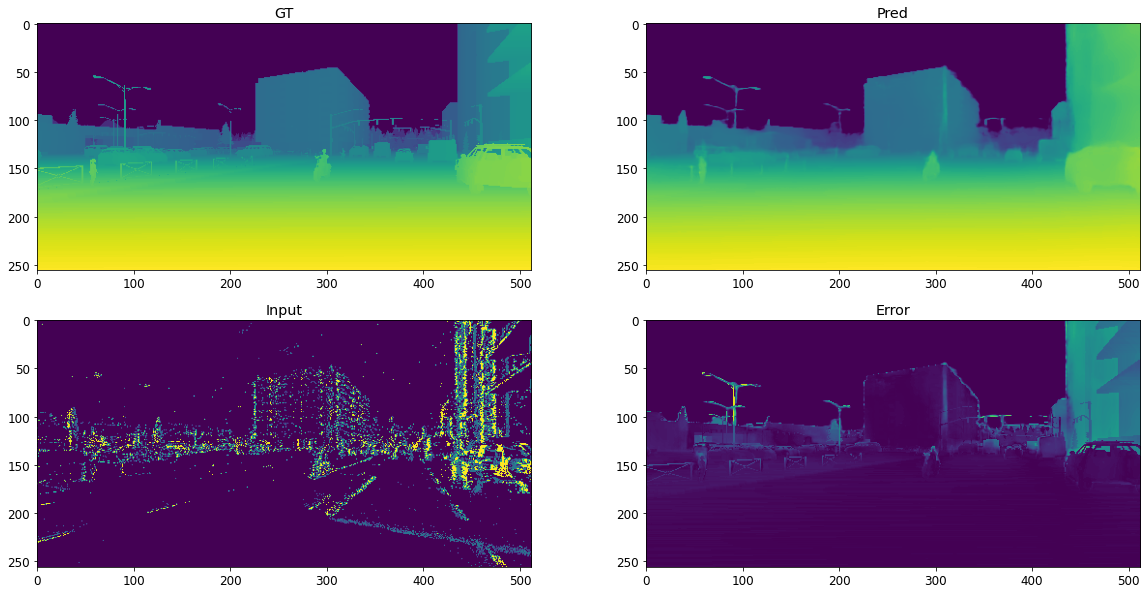

In [36]:
plt.rc('font', size=12)
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0,0].imshow(gt)
ax[0,0].set_title('GT')
ax[0,1].imshow(pred)
ax[0,1].set_title('Pred')
ax[1,0].imshow(input)
ax[1,0].set_title('Input')
ax[1,1].imshow(error)
ax[1,1].set_title('Error')
plt.show()
# plt.savefig(bbox_inches='tight')

In [31]:
cv2.imwrite(os.path.join(output_path, 'base_3.png'), error)

False

## 2. Event Voxel 분석

In [37]:
voxel_npy_path = '/home/work/main/jpark/Event_camera/data/Town05_sample/'
case0 = "Town05_sequence_0/events/voxels/05_000_0112_voxel.npy"
case0_rgb = "Town05_sequence_0/events/frames/0112.png"
case1 = "Town05_sequence_2/events/voxels/05_002_0017_voxel.npy"
case1_rgb = "Town05_sequence_2/events/frames/0017.png"


case0_path = os.path.join(voxel_npy_path, case0)
case0_rgb_path = os.path.join(voxel_npy_path, case0_rgb)
case1_path = os.path.join(voxel_npy_path, case1)
case1_rgb_path = os.path.join(voxel_npy_path, case1_rgb)

In [78]:
case0_voxel = np.load(case0_path)
case0_rgb = cv2.imread(case0_rgb_path)
case1_voxel = np.load(case1_path)
case1_rgb = cv2.imread(case1_rgb_path)

print(case0_voxel.shape, case0_voxel.mean(), case0_voxel.min(), case0_voxel.max(), case0_voxel.dtype)

(5, 256, 512) -0.0019851686 -5.9621 5.3890996 float32


### Feature Detector

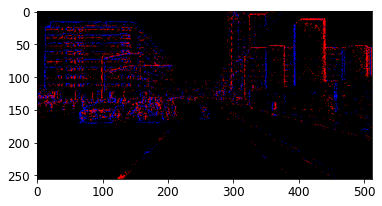

In [79]:
plt.imshow(case1_rgb)

In [115]:
block_size = 2
ksize = 3
k = 0.04
image = cv2.imread(case1_rgb_path, cv2.IMREAD_GRAYSCALE)
corners = cv2.cornerHarris(image, block_size, ksize, k)

# 코너 검출 결과 표시
threshold = 0.05
harris_image = case1_rgb.copy()
harris_image[corners > threshold * corners.max()] = [0, 255, 0] 

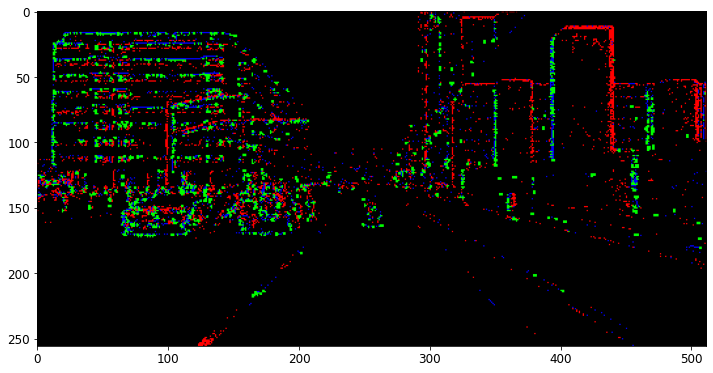

In [116]:
plt.figure(figsize=(12,8))
plt.imshow(harris_image)
plt.show()

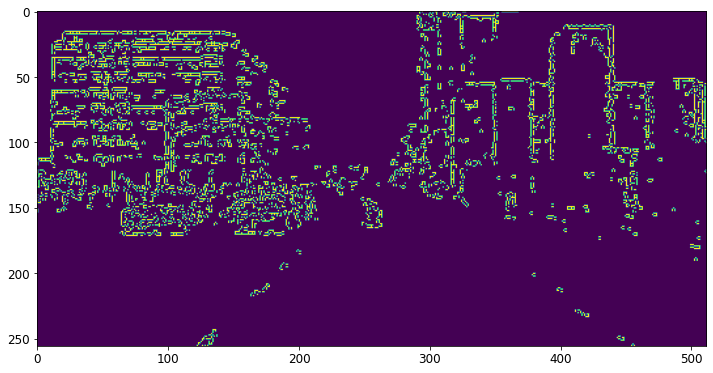

In [114]:
canny_image = cv2.Canny(case1_rgb, threshold1=300, threshold2=800)
plt.figure(figsize=(12,8))
plt.imshow(canny_image)
plt.show()

### Sparse Event Stacking

In [40]:
def viz_map(map):
    zero = np.zeros_like(map)
    neg = np.where(map <= -0.6, 1, 0.0)
    pos = np.where(map >= 0.6, 1, 0.0)
    viz = np.concatenate((pos[:,:,np.newaxis], zero[:,:,np.newaxis], neg[:,:,np.newaxis]), axis=2)
    return viz

def viz_event(voxel, total):
    plt.rc('font', size=12)
    fig, ax = plt.subplots(2,3, figsize=(24,8))
    ax[0,0].imshow(viz_map(voxel[0]))
    ax[0,0].set_title('t0')
    ax[0,1].imshow(viz_map(voxel[1]))
    ax[0,1].set_title('t1')
    ax[0,2].imshow(viz_map(voxel[2]))
    ax[0,2].set_title('t2')
    ax[1,0].imshow(viz_map(voxel[3]))
    ax[1,0].set_title('t3')
    ax[1,1].imshow(viz_map(voxel[4]))
    ax[1,1].set_title('t4')
    ax[1,2].imshow(total)
    ax[1,2].set_title('Event Voxel')
    plt.show()

def event_n_voxel(voxel, n):
    neg_concat = np.zeros((256,512))
    pos_concat = np.zeros((256,512))
    zeros = np.zeros((256,512))

    for event in (voxel[-n:]):
        neg = np.where(event <= -0.6, 1.0, 0.0)
        pos = np.where(event >= 0.6, 1.0, 0.0)
        neg_concat[neg != 0 ] = neg[neg != 0 ]
        pos_concat[pos != 0 ] = pos[pos != 0 ]
    
    occ = (np.sum(neg_concat !=0) + np.sum(pos_concat != 0))
    total_image = np.concatenate((pos_concat[:, :, None], zeros[:, :, None], neg_concat[:, :, None]), axis=2)
    print('total_image:', total_image.shape, total_image.dtype, total_image.mean(), 'occ_percentage:',(occ/(256*512)).round(4))
    return total_image

def event_stack_n_voxel(voxel, n):
    neg_concat = np.zeros((256,512))
    pos_concat = np.zeros((256,512))
    zeros = np.zeros((256,512))
    result = []

    for event in (voxel[-n:]):
        neg = np.where(event <= -0.6, 1.0, 0.0)
        pos = np.where(event >= 0.6, 1.0, 0.0)
        neg_concat[neg != 0 ] = neg[neg != 0 ]
        pos_concat[pos != 0 ] = pos[pos != 0 ]
    
        occ = (np.sum(neg_concat !=0) + np.sum(pos_concat != 0))
        total_image = np.concatenate((pos_concat[:, :, None], zeros[:, :, None], neg_concat[:, :, None]), axis=2)
        print('total_image:', total_image.shape, total_image.dtype, total_image.mean(), 'occ_percentage:',(occ/(256*512)).round(4))
        result.append(total_image)
    return result

def viz_stack_event(stack):
    plt.rc('font', size=12)
    fig, ax = plt.subplots(2,3, figsize=(24,8))
    ax[0,0].imshow(stack[0])
    ax[0,0].set_title('t0')
    ax[0,1].imshow(stack[1])
    ax[0,1].set_title('t1')
    ax[0,2].imshow(stack[2])
    ax[0,2].set_title('t2')
    ax[1,0].imshow(stack[3])
    ax[1,0].set_title('t3')
    ax[1,1].imshow(stack[4])
    ax[1,1].set_title('t4')
    ax[1,2].imshow(stack[4])
    ax[1,2].set_title('Event Voxel')
    plt.show()

total_image: (256, 512, 3) float64 0.0027796427408854165 occ_percentage: 0.0083
total_image: (256, 512, 3) float64 0.007631937662760417 occ_percentage: 0.0229
total_image: (256, 512, 3) float64 0.011515299479166666 occ_percentage: 0.0345
total_image: (256, 512, 3) float64 0.015462239583333334 occ_percentage: 0.0464
total_image: (256, 512, 3) float64 0.01761627197265625 occ_percentage: 0.0528


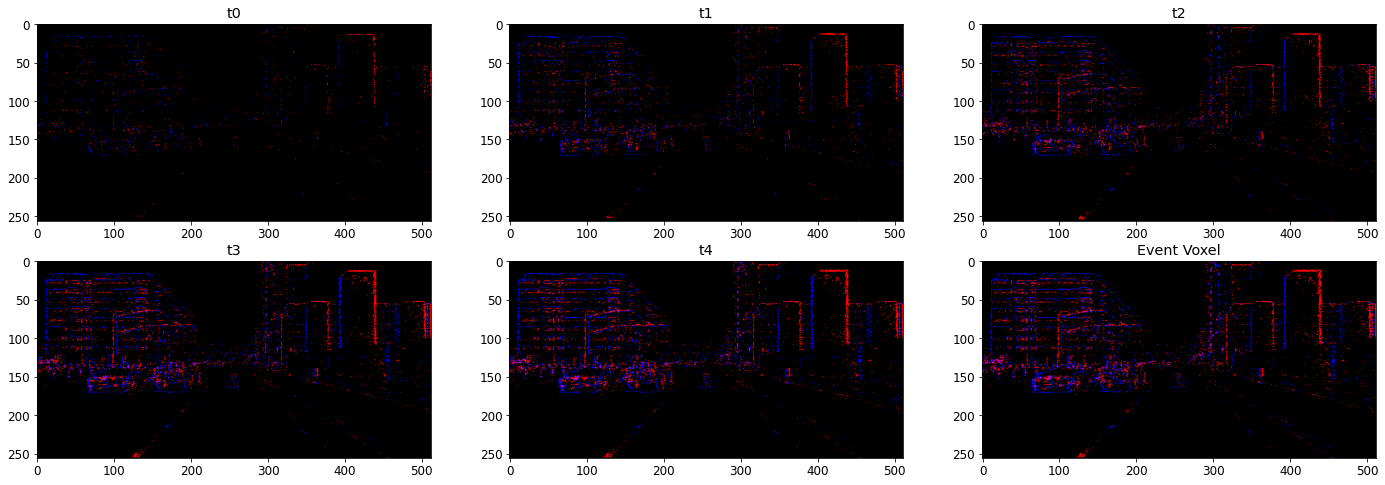

In [41]:
stack = event_stack_n_voxel(case1_voxel,5)
viz_stack_event(stack)

total_image: (256, 512, 3) float64 0.044347127278645836 occ_percentage: 0.133


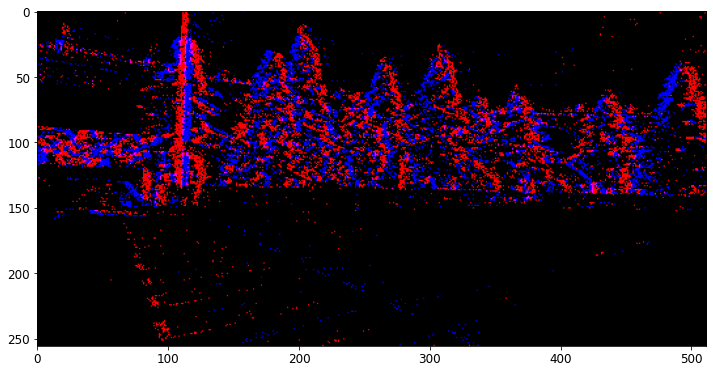

In [42]:
stack2_voxel = event_n_voxel(case0_voxel,2)
plt.figure(figsize=(12,8))
plt.imshow(stack2_voxel)
plt.show()

total_image: (256, 512, 3) float64 0.01761627197265625 occ_percentage: 0.0528


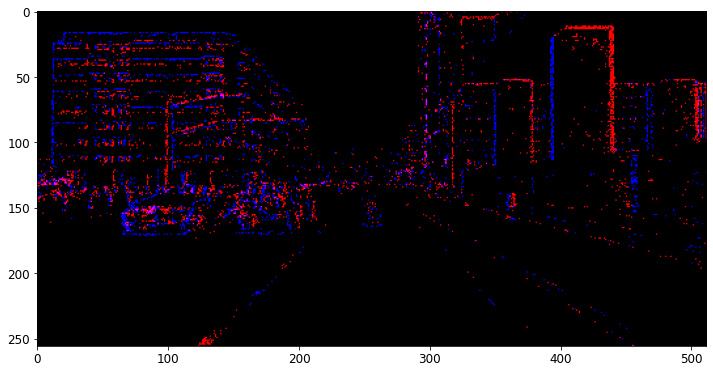

In [43]:
stack2_voxel = event_n_voxel(case1_voxel,5)
plt.figure(figsize=(12,8))
plt.imshow(stack2_voxel)
plt.show()

In [44]:
# cv2.imwrite(os.path.join(output_path, '2stack_events.png'), stack2_voxel*255.0)

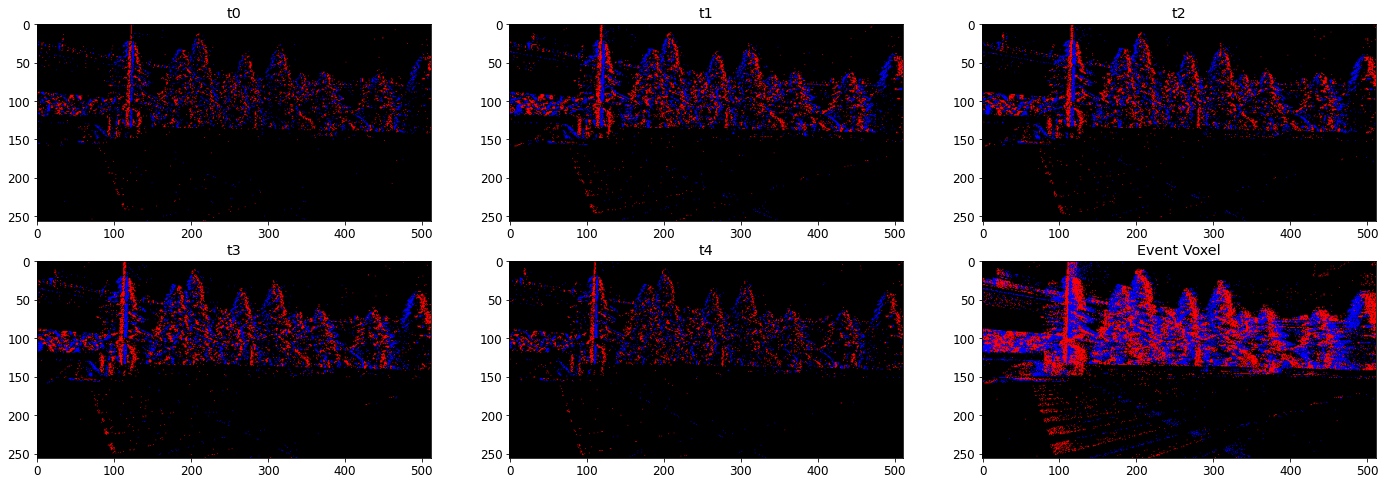

In [118]:
viz_event(case0_voxel, case0_rgb)

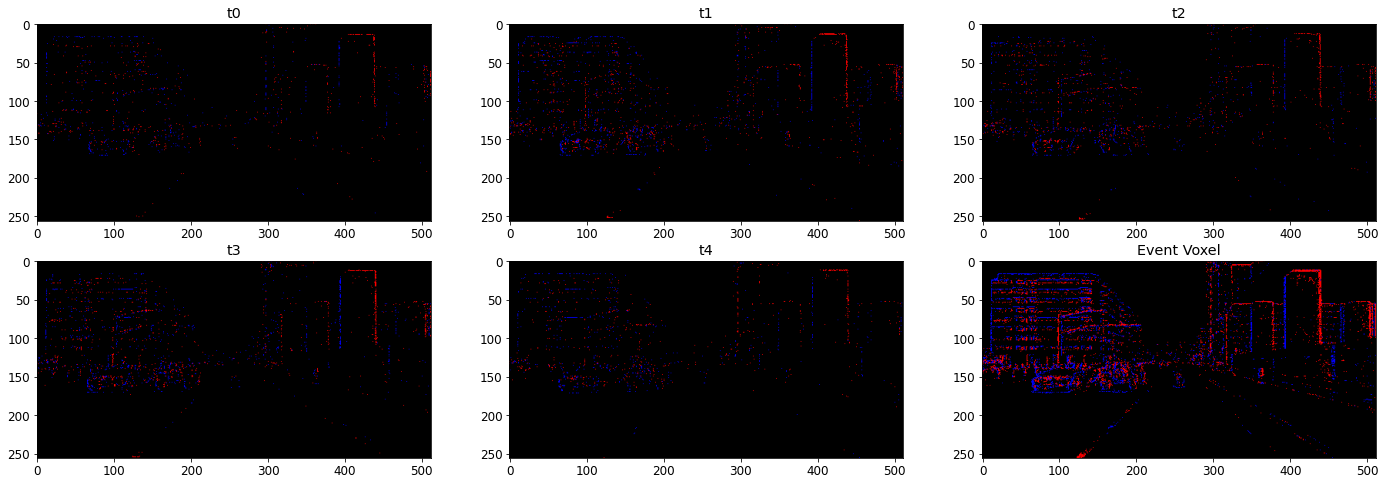

In [119]:
viz_event(case1_voxel, case1_rgb)